# Tema 6 - Ejercicio 
## Métodos de regresión

En la librería MASS de R podemos encontrar el dataset Boston, el cual incluye 
506 observaciones de 14 variables relacionadas con el mercado de la vivienda de
dicha ciudad estadounidense. Puede encontrarse información detallada sobre el 
contenido de dichas variables en el siguiente enlace:

https://www.rdocumentation.org/packages/MASS/versions/7.3-54/topics/Boston

A partir de los datos de dicho dataset, construya un modelo de regresión lineal
para predecir el precio de la vivienda en Boston utilizando como output la
variable medv (valor mediano de viviendas ocupadas por sus propietarios en
miles de dólares).
Para realizar el ejercicio, se recomienda crear un modelo inicial con todas las
variables para seguidamente eliminar de forma secuencial aquellas variables
no significativas del modelo siguiendo alguno de los métodos explicados en el
material complementario del Tema 6.
Una vez obtenido el modelo final, realice una diagnosis similar a la presentada
en los ejemplos del material complementario, comentando en detalle los
resultados obtenidos.
Por último, utilizando este modelo realice un ejercicio de predicción asignando
5 valores diferentes a cada una de las variables que componen el modelo.
Valore el resultado de estas predicciones indicando si el resultado tiene sentido
económico.

Importamos dependencias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb

#matplotlib inline <- if present the heatmap is not shown!
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.linear_model import LinearRegression

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Paso 1: importar datos

El dataset está disponible en la propia librería scikit-learn

In [3]:
#from sklearn.datasets import load_boston
#boston = load_boston()

    108         `load_boston` has been removed from scikit-learn since version 1.2.
   (...)
    154         """
    155     )
--> 156     raise ImportError(msg)
    157 try:
    158     return globals()[name]

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

**The Boston housing prices dataset has an ethical problem**: as  <br>
investigated in [1], the authors of this dataset engineered a      <br>
non-invertible variable "B" assuming that racial self-segregation had a <br>
positive impact on house prices [2]. Furthermore the goal of the <br>
research that led to the creation of this dataset was to study the <br>
impact of air quality but it did not give adequate demonstration of the <br>
validity of this assumption. <br>

The scikit-learn maintainers therefore strongly discourage the use of <br>
this dataset unless the purpose of the code is to study and educate <br>
about ethical issues in data science and machine learning. <br>

In this special case, you can fetch the dataset from the original source ...

NOTA:
Estoy de acuerdo con los mantenedores de sckit-learn. Pero para poder comparar los resultados de R con Python, voy a usar el mismo .csv que en R. 

In [4]:
bostonR = pd.read_csv(r"boston.csv",sep=',',usecols=[*range(1,16)])

## Paso 2: procesar datos

In [5]:
bostonR.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv,pred
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,32.025398
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,24.690538
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,33.434376
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,32.825201
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,29.983099


In [6]:
#check for nulls/nan  -we know there is none-
bostonR.isnull().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
pred       0
dtype: int64

In [7]:
#we create a new dataframe without the R predictions
boston = bostonR.drop('pred', axis=1)  #drop creates a copy of the dataframe by default  <- OJO!
boston.head(5)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [8]:
boston.shape  #ok, exact dataframe as in R

(506, 14)

In [9]:
#Summary
boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


La variable dependiente en este estudio es medv (valor medio de la vivienda en 1000 de $).
Al ser numérica, está incluida en el resumen estadístico.

En el sumario estadístico, se puede ver que algunas variables tienen una media y mediana bastante separadas:   crim, zn <br>
Vamos a examinar los diagramas de caja para estar seguro

In [10]:
boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'black', 'lstat', 'medv'],
      dtype='object')

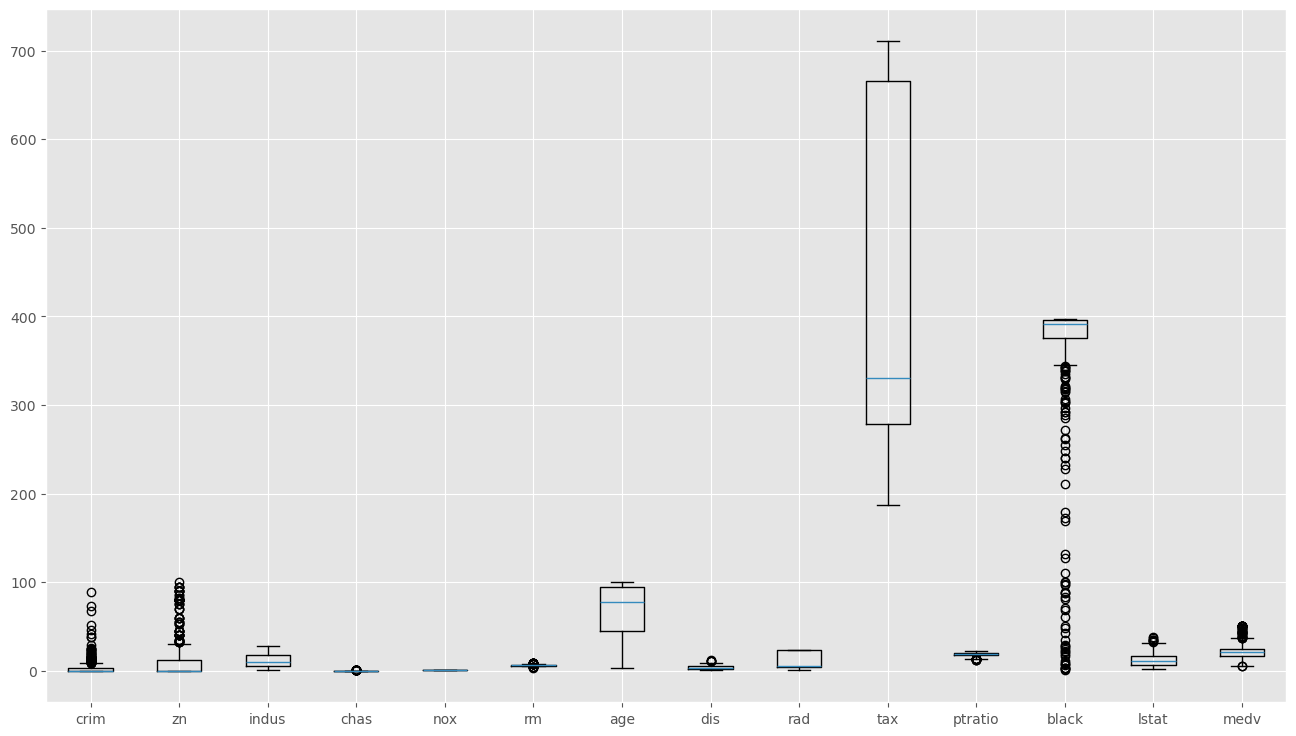

In [11]:
#plt.boxplot(boston['crim'])
plt.boxplot(boston, labels=boston.columns)  # or list(boston), it also returns a list with the colums
plt.show()

Hay otras dos variables "sospechosas" más, examinamos las 4 con más detalle

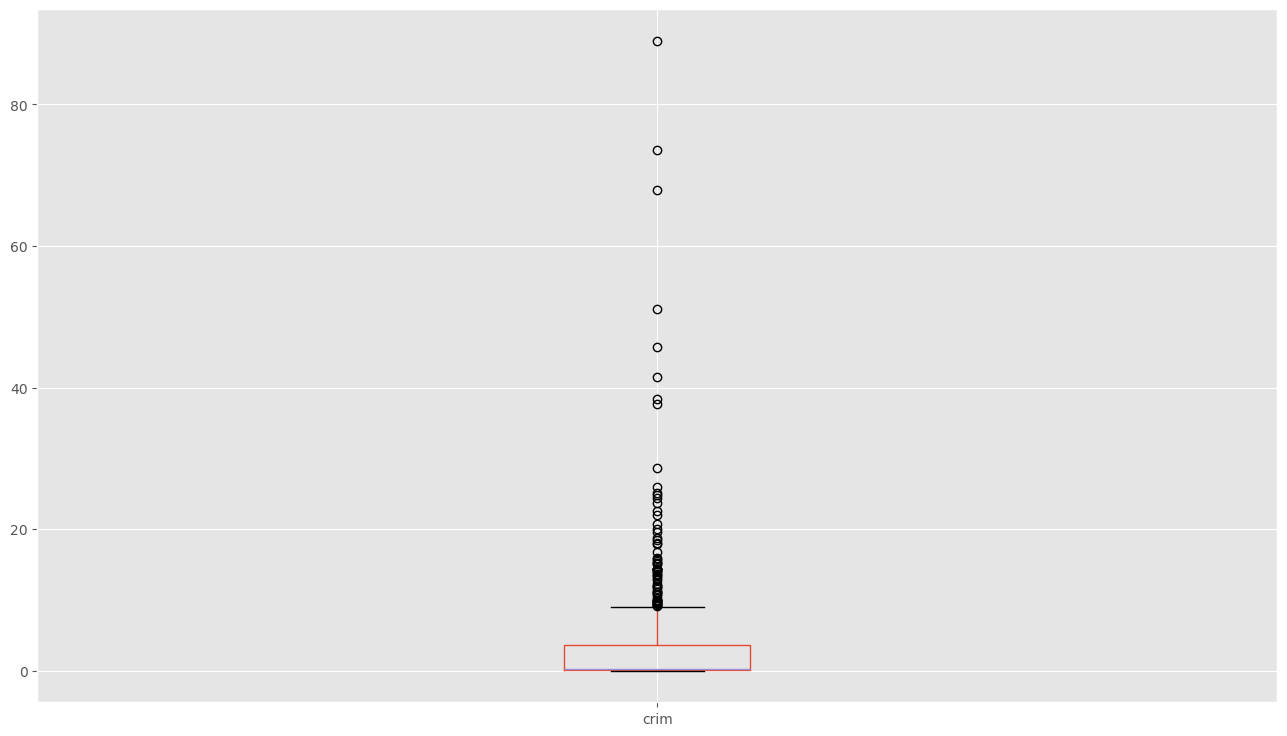

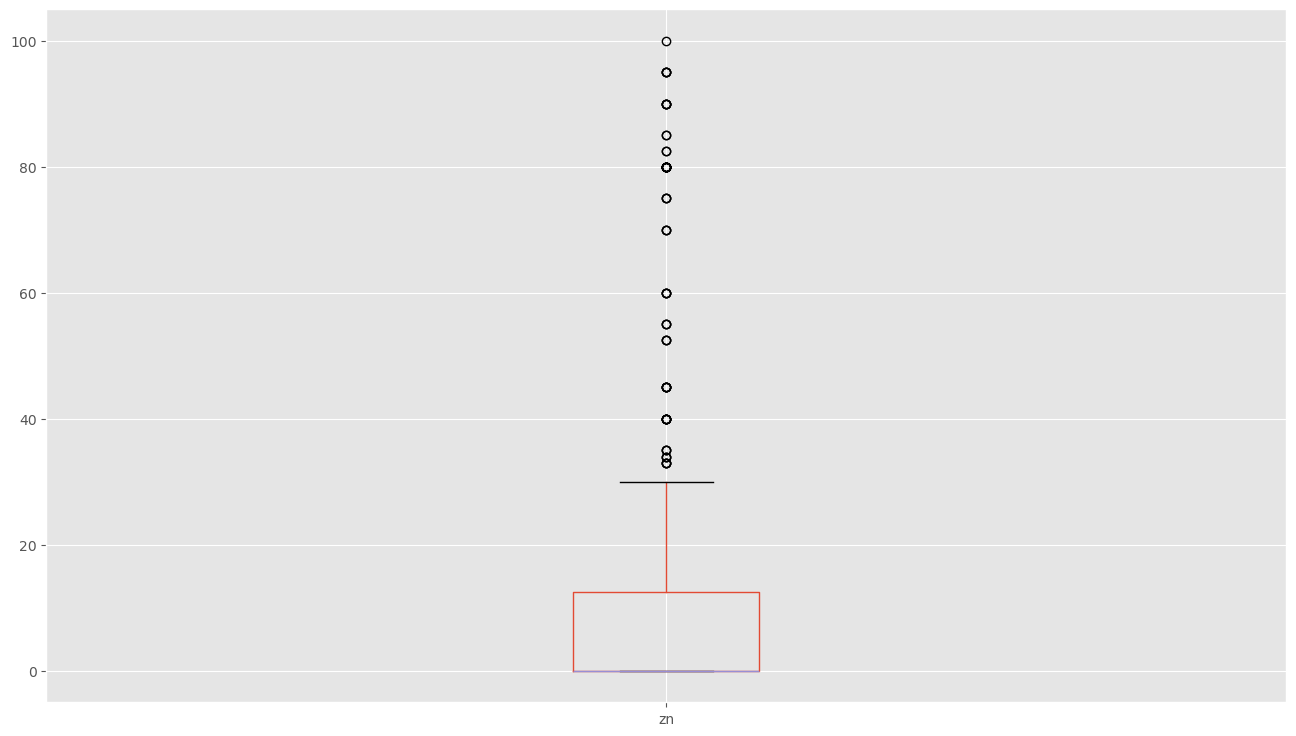

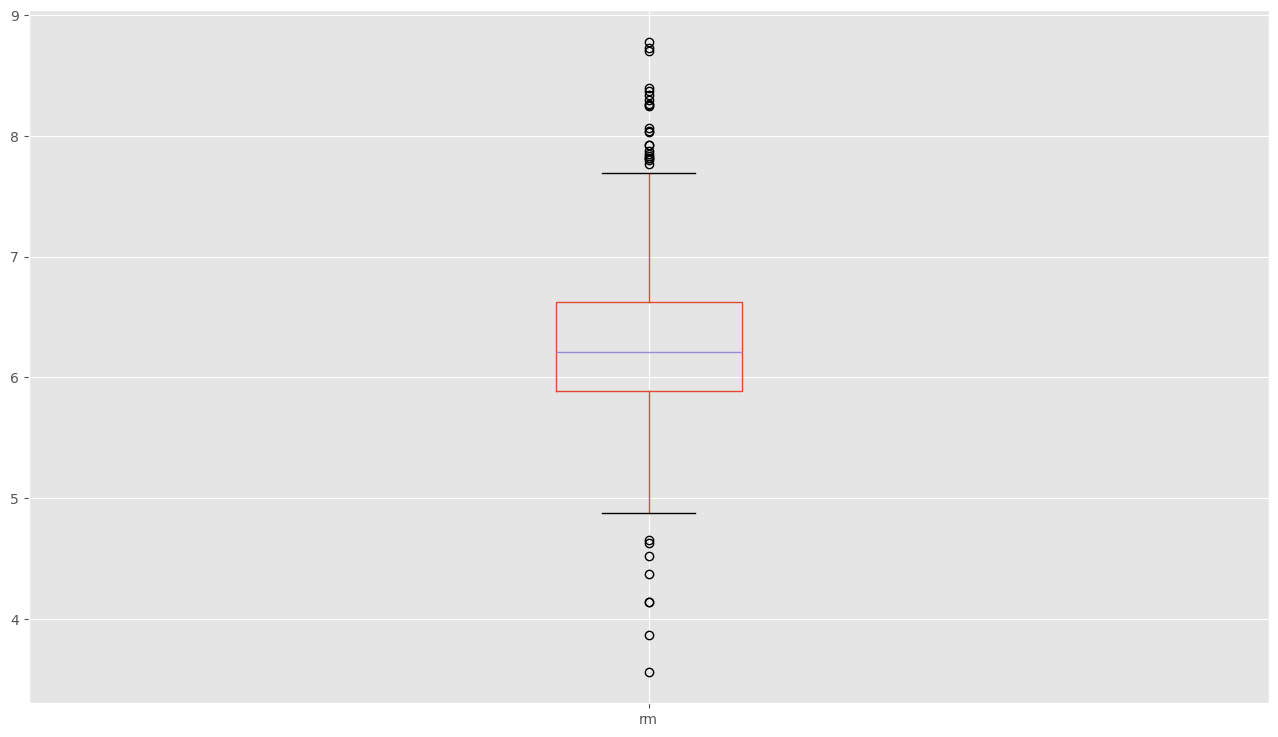

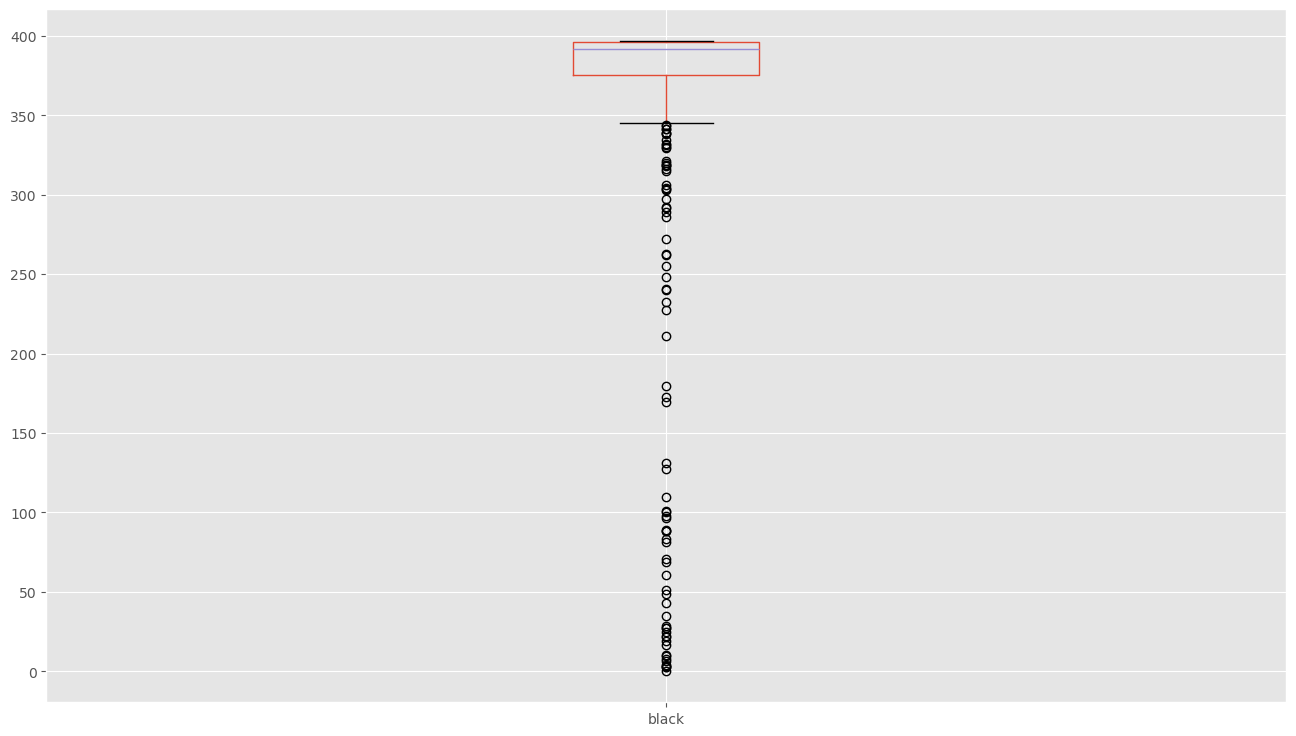

In [12]:
#for column in boston:
for column in ['crim','zn','rm','black']:    
    plt.figure()
    boston.boxplot([column]) 
    plt.show()

[copiado del trabajo en R] <br>
Al hacer los diagramas de caja de todos (por si acaso), he visto que también hay muchos valores atípicos para black y rm.
(rm no creo que afecte tanto, porque el rango es muy pequeño -de hecho la mediana y la media de rm no son muy diferentes-).  <br>
Entiendo que estas variables pueden provocar efectos indeseados en el conjunto.

### Análisis de correlación

Para poder establecer un modelo de regresión lineal múltiple, lo primero es estudiar
la relación que existe entre variables. Para ello, comenzamos obteniendo la matriz de
correlación entre todas las variables disponibles

In [13]:
corr_matrix = boston.corr().round(decimals=3)   #pandas dataframe include a correlation method :)
corr_matrix

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
crim,1.000,-0.200,0.407,-0.056,0.421,-0.219,0.353,-0.380,0.626,0.583,0.290,-0.385,0.456,-0.388
zn,-0.200,1.000,-0.534,-0.043,-0.517,0.312,-0.570,0.664,-0.312,-0.315,-0.392,0.176,-0.413,0.360
indus,0.407,-0.534,1.000,0.063,0.764,-0.392,0.645,-0.708,0.595,0.721,0.383,-0.357,0.604,-0.484
chas,-0.056,-0.043,0.063,1.000,0.091,0.091,0.087,-0.099,-0.007,-0.036,-0.122,0.049,-0.054,0.175
nox,0.421,-0.517,0.764,0.091,1.000,-0.302,0.731,-0.769,0.611,0.668,0.189,-0.380,0.591,-0.427
rm,-0.219,0.312,-0.392,0.091,-0.302,1.000,-0.240,0.205,-0.210,-0.292,-0.356,0.128,-0.614,0.695
age,0.353,-0.570,0.645,0.087,0.731,-0.240,1.000,-0.748,0.456,0.506,0.262,-0.274,0.602,-0.377
dis,-0.380,0.664,-0.708,-0.099,-0.769,0.205,-0.748,1.000,-0.495,-0.534,-0.232,0.292,-0.497,0.250
rad,0.626,-0.312,0.595,-0.007,0.611,-0.210,0.456,-0.495,1.000,0.910,0.465,-0.444,0.489,-0.382
tax,0.583,-0.315,0.721,-0.036,0.668,-0.292,0.506,-0.534,0.910,1.000,0.461,-0.442,0.544,-0.469


Se obtiene por supuesto el mismo resultado que en R. <br>

Los valores que parecen más relacionados con el precio de la vivienda son 'lstat' (correlación negativa) y 'rm' (positiva). <br>
(Parece lógico -y un poco clasista también, pero bueno-: cuantas más habitaciones, mayor precio, cuanto más porcentaje de 'clase baja' en la zona, menor precio). <br>
Las variables que parecen menos relacionados con el precio de la vivienda son 'chas', 'dis', 'black' y 'zn'. 
(Por no hablar de la variable 'black'). <br>

También se ve que están muy relacionadas entre sí 'indus' y 'nox', 'tax' y 'rad'. <br>
(Investigando en internet he visto que la multicolinealidad puede ser un problema).

Si queremos algo un poco más visual:

<Axes: >

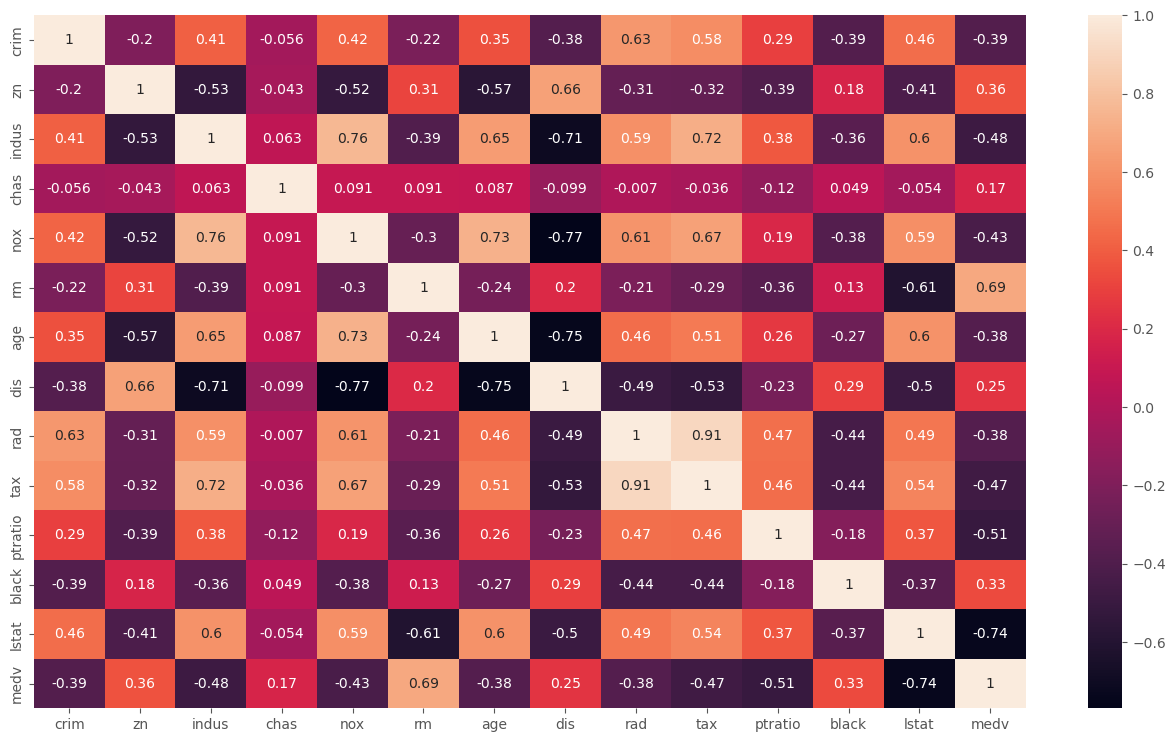

In [14]:
sb.heatmap(data=corr_matrix, annot=True)  # annot=True to show values inside the cells

<br>

Y algo equivalente a **ggpairs** de **R** (PairGrid from seaborn): <br>

In [15]:
from scipy.stats import pearsonr
def reg_coef(x,y,label=None,color=None,**kwargs):
    ax = plt.gca()
    r,p = pearsonr(x,y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5,0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

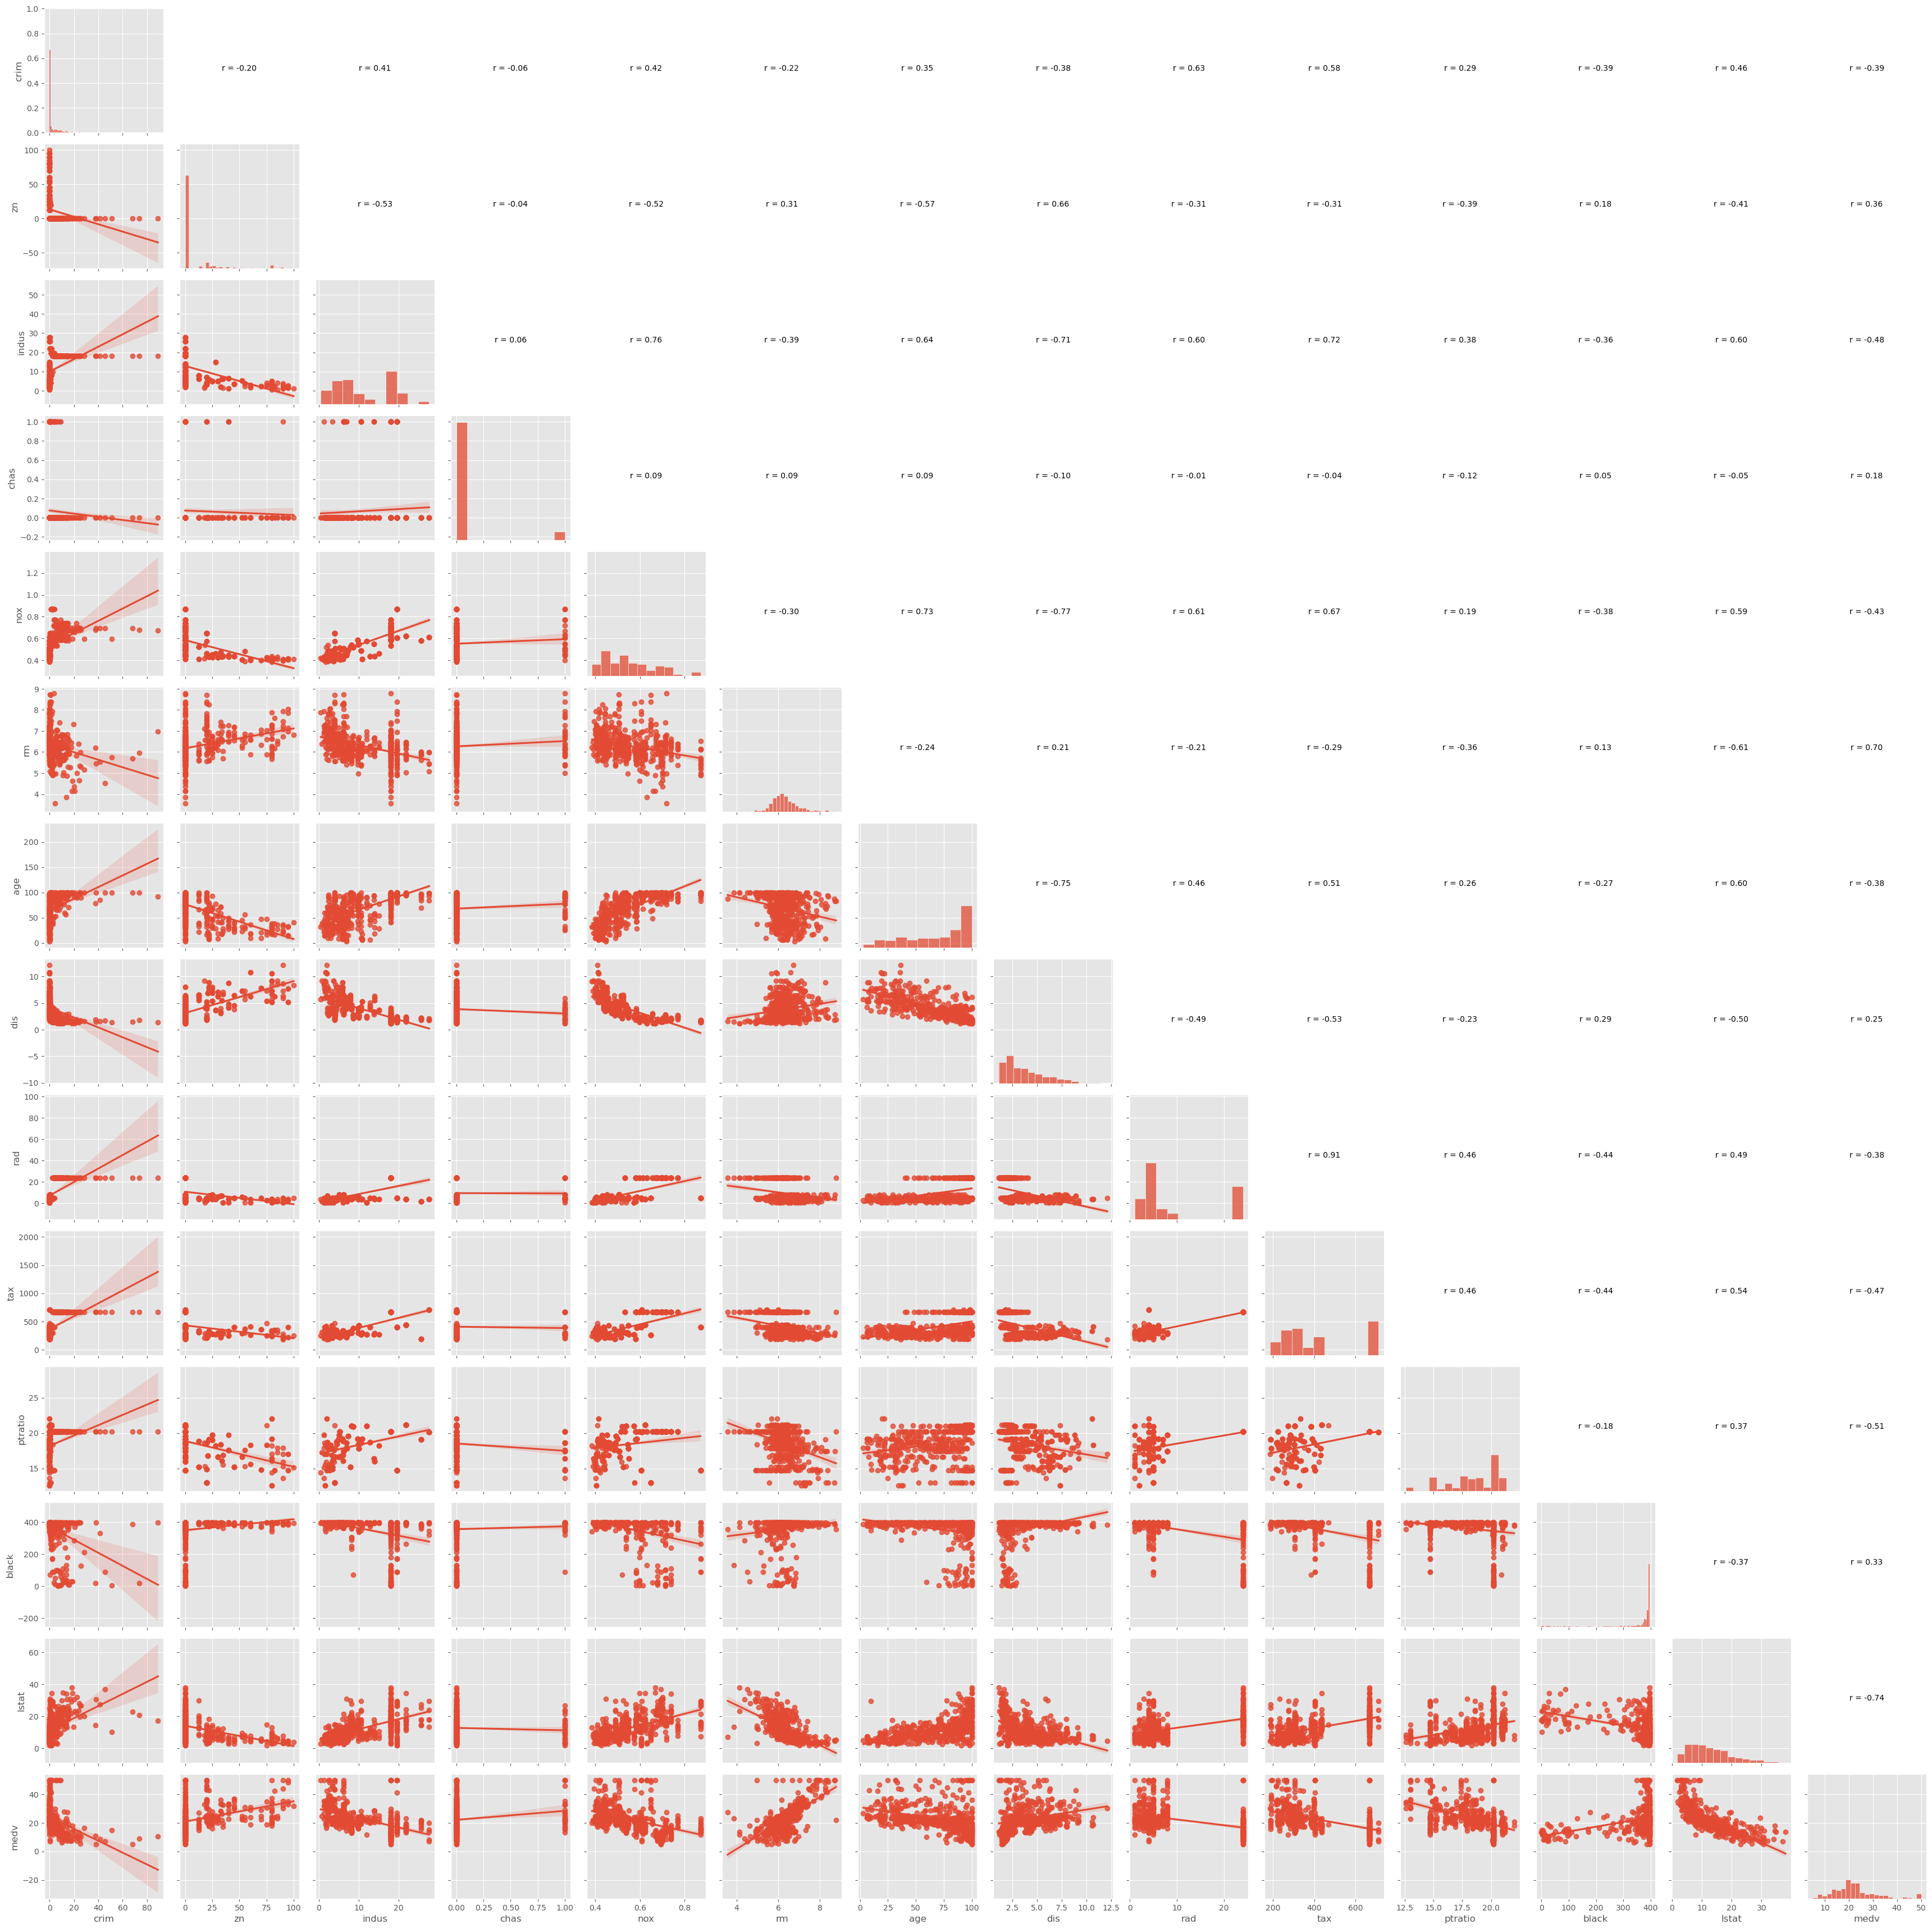

In [16]:
g = sb.PairGrid(boston)
g.map_upper(reg_coef)
g.map_diag(sb.histplot)
g.map_lower(sb.regplot)

Lo mismo pere eligiendo menos variables, para que se vea mejor:

In [17]:
boston_medv = boston[["crim","indus","ptratio","rm", "lstat","medv"]]
boston_medv.head(3)

,crim,indus,ptratio,rm,lstat,medv
0,0.00632,2.31,15.3,6.575,4.98,24.0
1,0.02731,7.07,17.8,6.421,9.14,21.6
2,0.02729,7.07,17.8,7.185,4.03,34.7


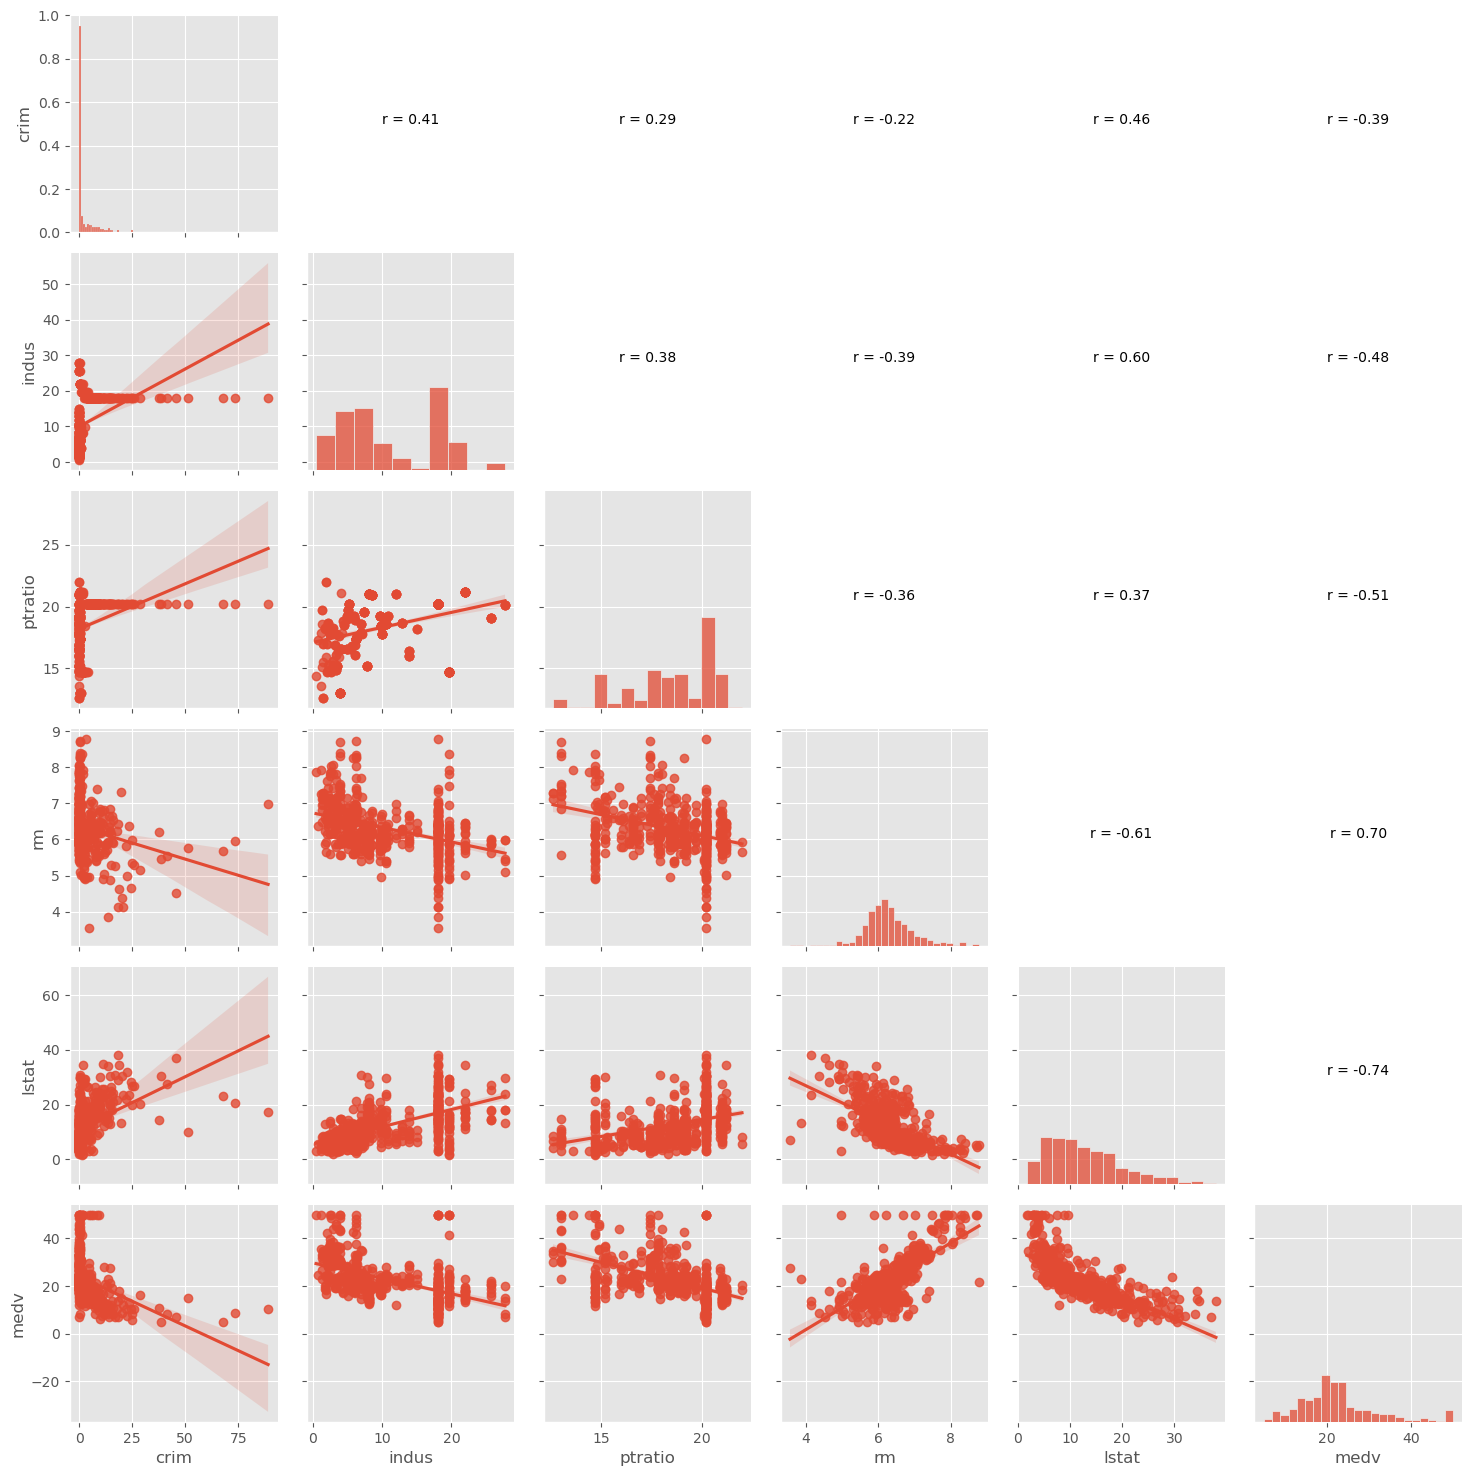

In [18]:
g = sb.PairGrid(boston_medv)
g.map_upper(reg_coef)
g.map_diag(sb.histplot)
g.map_lower(sb.regplot)

Una vez visto todo esto <br>
(
- variables que son cualitativas como chas y rad <br>
- variables que están muy muy relacionadas entre sí, como tax y rad <br>
- variables que tienen muchos valores atípicos como crim, zn y black <br>
) <br>
estimamos el modelo con todas ellas, y luego utilizaremos el criterio AIC para ver si es conveniente eliminar alguna. <br>

### Modelo de regresión linear

Necesitamos separar los predictores de la variable dependiente

In [19]:
y = boston['medv']
X = boston.drop(['medv'], axis=1)
print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [20]:
model = LinearRegression()  # Ordinary least squares Linear Regression
model.fit(X,y)


LinearRegression()

Cálculo de **R²** del modelo

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html  <br>

Return the coefficient of determination of the prediction. <br>

The coefficient of determination R² is defined as ...

In [21]:
#display regression coefficients and R-squared value of model
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)
print("R-squared: ", round(model.score(X,y), 4))

Intercept:  36.45948838509025
Coefficients:  [-1.08011358e-01  4.64204584e-02  2.05586264e-02  2.68673382e+00
 -1.77666112e+01  3.80986521e+00  6.92224640e-04 -1.47556685e+00
  3.06049479e-01 -1.23345939e-02 -9.52747232e-01  9.31168327e-03
 -5.24758378e-01]
R-squared:  0.7406


**Mismos valores que en R**

Por lo visto, scikit learn se usa sobre todo para machine learning, por lo que solo se necesita realizar predicciones. <br>
No hay un método que devuelva un resumen del modelo como en R

En algún sitio en internet: <br>
"In general, scikit-learn is designed for prediction, while statsmodels is more suited for explanatory analysis."

Usando otra librería (**statsmodels**):  <br>

**Nota**: <br>
Al principio obtuve otros valores (diferente R², diferentes coeficientes ...) porque en esta librería, por defecto no hay interceptor. <br>
Al añadirlo, salen los mismos valores que con R y con scikit learn :)

In [22]:
import statsmodels.api as sm

X = sm.add_constant(X)   #  Our model needs an intercept so we add a column of 1s   (if no intercept -> different result)

model2 = sm.OLS(y,X) # Ordinary Least Square ,)  
model_OLS_fit = model2.fit()  

model_OLS_fit.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          6.72e-135
Time:                        02:21:30   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.000      26.432      46.487
crim          -0.1080      0.033     -3.287      0.001      -0.173      -0.043
zn             0.0464      0.014      3.382      0.001       0.019       0.073
indus          0.0206      0.061      0.334      0.738      -0.100       0.141
chas           2.6867      0.862      3.118      0.002       0.994       4.380
nox          -17.7666      3.820     -4.651      0.000     -25.272     -10.262
rm             3.8099      0.418      9.116      0.000       2.989       4.631
age            0.0007      0.013      0.052      0.958      -0.025       0.027
dis           -1.4756      0.199     -7.398      0.000      -1.867      -1.084
rad            0.3060      0.066      4.613      0.000       0.176       0.436
tax           -0.0123      0.004     -3.280      0.001      -0.020      -0.005
ptratio       -0.9527      0.131     -7.283      0.000      -1.210      -0.696
black          0.0093      0.003      3.467      0.001       0.004       0.015
lstat         -0.5248      0.051    -10.347      0.000      -0.624      -0.425
==============================================================================
Omnibus:                      178.041   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              783.126
Skew:                           1.521   Prob(JB):                    8.84e-171
Kurtosis:                       8.281   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se obtienen los mismos valores que en R :)


Ahora algo parececido al criterio Akaike ...

In [23]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [24]:
# Build step forward feature selection
sfs1 = sfs(model, k_features = 11, forward=True, floating=False, scoring='r2',cv=0, verbose=8)

In [25]:
# Perform SFFS
sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 1/11 -- score: 0.5441462975864799[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 2/11 -- score: 0.6385616062603403[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 3/11 -- score: 0.6786241601613111[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 4/11 -- score: 0.6903077016842538[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 5/11 -- score: 0.7080892893529662[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 6/11 -- score: 0.7157742117396082[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 7/11 -- score: 0.7221614025277103[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s

[2025-02-20 02:21:30] Features: 8/11 -- score: 0.

In [26]:
sfs1.subsets_

{1: {'feature_idx': (13,),
  'cv_scores': array([0.5441463]),
  'avg_score': 0.5441462975864799,
  'feature_names': ('lstat',)},
 2: {'feature_idx': (6, 13),
  'cv_scores': array([0.63856161]),
  'avg_score': 0.6385616062603403,
  'feature_names': ('rm', 'lstat')},
 3: {'feature_idx': (6, 11, 13),
  'cv_scores': array([0.67862416]),
  'avg_score': 0.6786241601613111,
  'feature_names': ('rm', 'ptratio', 'lstat')},
 4: {'feature_idx': (6, 8, 11, 13),
  'cv_scores': array([0.6903077]),
  'avg_score': 0.6903077016842538,
  'feature_names': ('rm', 'dis', 'ptratio', 'lstat')},
 5: {'feature_idx': (5, 6, 8, 11, 13),
  'cv_scores': array([0.70808929]),
  'avg_score': 0.7080892893529662,
  'feature_names': ('nox', 'rm', 'dis', 'ptratio', 'lstat')},
 6: {'feature_idx': (4, 5, 6, 8, 11, 13),
  'cv_scores': array([0.71577421]),
  'avg_score': 0.7157742117396082,
  'feature_names': ('chas', 'nox', 'rm', 'dis', 'ptratio', 'lstat')},
 7: {'feature_idx': (4, 5, 6, 8, 11, 12, 13),
  'cv_scores': array

In [27]:
#type(sfs1.subsets_[11]) # a dict !!!!!

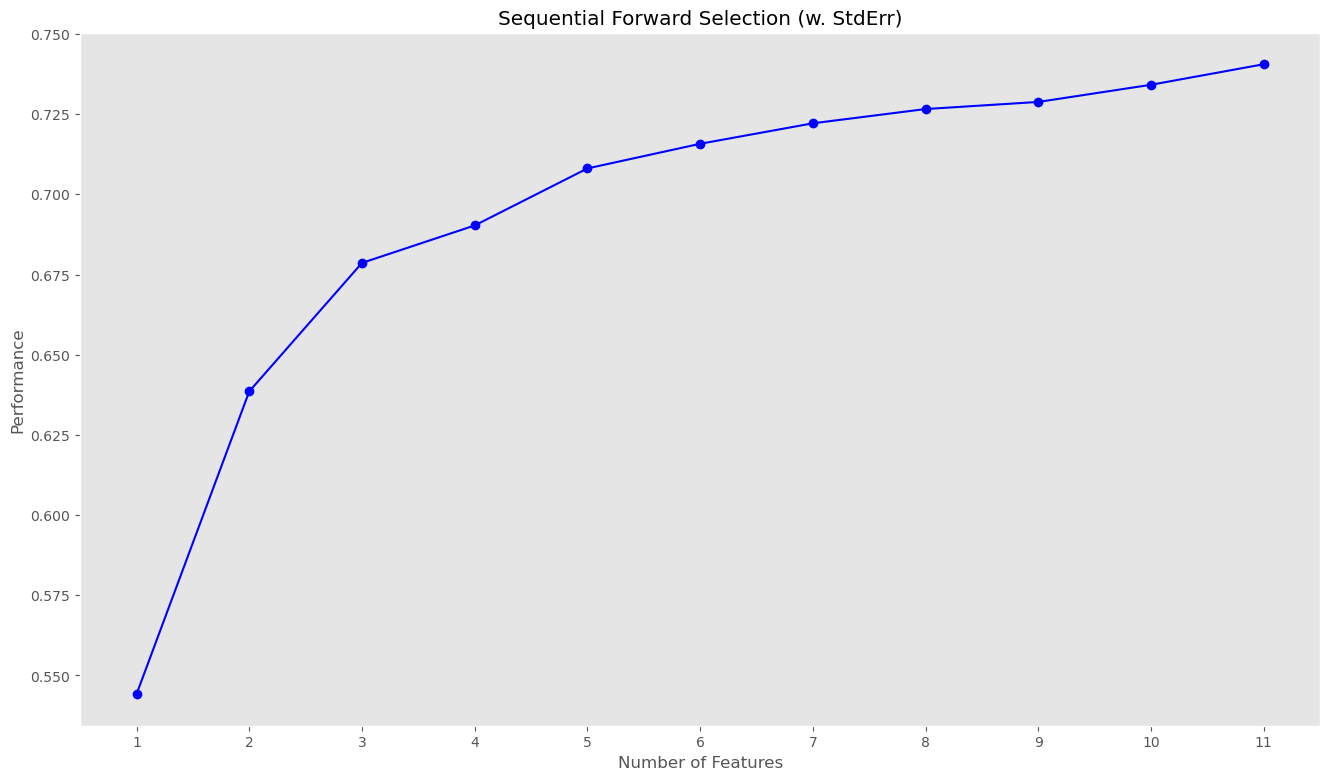

In [28]:
fig = plot_sfs(sfs1.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [29]:
from sklearn.feature_selection import RFE

# Apply RFE with logistic regression
#model = LogisticRegression()
rfe = RFE(model, n_features_to_select=11)
X_train_rfe = rfe.fit_transform(X, y)

print("Selected features:", X.columns[rfe.get_support()])

Selected features: Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'dis', 'rad', 'tax',
       'ptratio', 'lstat'],
      dtype='object')


(con RFE entra indus y sale black)

In [30]:
from sklearn.preprocessing import PolynomialFeatures
poly2_object = PolynomialFeatures(degree=2, include_bias=False)
lstat_2 = poly2_object.fit_transform(boston[['lstat']])
#lstat_2.shape  # (506, 2)
#type(lstat_2)  # numpy.ndarray

In [31]:
lstat_2_df = pd.DataFrame(lstat_2)

In [32]:
boston_new = boston.drop('medv', axis=1)
boston_new = boston_new.drop('indus', axis=1)
boston_new = boston_new.drop('age', axis=1)
#si quisiéramos añadir esas columnas al dataframe ..
boston_new = boston_new.drop('lstat', axis=1)
boston_new = boston_new.join(lstat_2_df.rename(columns={0:'lstat',1:'lstat2'}))
boston_new.head(3)

,crim,zn,chas,nox,rm,dis,rad,tax,ptratio,black,lstat,lstat2
0,0.00632,18.0,0,0.538,6.575,4.0900,1,296,15.3,396.90,4.98,24.8004
1,0.02731,0.0,0,0.469,6.421,4.9671,2,242,17.8,396.90,9.14,83.5396
2,0.02729,0.0,0,0.469,7.185,4.9671,2,242,17.8,392.83,4.03,16.2409


In [33]:
model.fit(boston_new, y)

LinearRegression()

In [34]:
#display regression coefficients and R-squared value of model
print("Intercept: ", model.intercept_)
print("Coefficients: ", model.coef_)
print("R-squared: ", round(model.score(boston_new,y), 4))

Intercept:  42.12418713879222
Coefficients:  [-1.49072088e-01  2.12805361e-02  2.58982075e+00 -1.35345215e+01
  3.23317418e+00 -1.35789175e+00  2.71744236e-01 -9.54552995e-03
 -7.90820080e-01  8.17407361e-03 -1.66956671e+00  3.30545338e-02]
R-squared:  0.7868


In [35]:
# Equivalent model from statsmodels to check all values
boston_new_OLS = sm.add_constant(boston_new)
boston_new_OLS.head(3)

,const,crim,zn,chas,nox,rm,dis,rad,tax,ptratio,black,lstat,lstat2
0,1.0,0.00632,18.0,0,0.538,6.575,4.0900,1,296,15.3,396.90,4.98,24.8004
1,1.0,0.02731,0.0,0,0.469,6.421,4.9671,2,242,17.8,396.90,9.14,83.5396
2,1.0,0.02729,0.0,0,0.469,7.185,4.9671,2,242,17.8,392.83,4.03,16.2409


In [37]:
model2 = sm.OLS(y,boston_new_OLS) # Ordinary Least Square ,)  
model_OLS_fit = model2.fit()  

model_OLS_fit.summary()  

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   medv   R-squared:                       0.787
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     151.6
Date:                Thu, 20 Feb 2025   Prob (F-statistic):          8.63e-157
Time:                        02:22:14   Log-Likelihood:                -1449.2
No. Observations:                 506   AIC:                             2924.
Df Residuals:                     493   BIC:                             2979.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         42.1242      4.633      9.093      0.000      33.022      51.226
crim          -0.1491      0.030     -4.968      0.000      -0.208      -0.090
zn             0.0213      0.012      1.703      0.089      -0.003       0.046
chas           2.5898      0.775      3.340      0.001       1.067       4.113
nox          -13.5345      3.230     -4.191      0.000     -19.880      -7.189
rm             3.2332      0.373      8.673      0.000       2.501       3.966
dis           -1.3579      0.169     -8.032      0.000      -1.690      -1.026
rad            0.2717      0.058      4.718      0.000       0.159       0.385
tax           -0.0095      0.003     -3.111      0.002      -0.016      -0.004
ptratio       -0.7908      0.118     -6.697      0.000      -1.023      -0.559
black          0.0082      0.002      3.365      0.001       0.003       0.013
lstat         -1.6696      0.119    -14.029      0.000      -1.903      -1.436
lstat2         0.0331      0.003     10.337      0.000       0.027       0.039
==============================================================================
Omnibus:                      141.913   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              688.195
Skew:                           1.148   Prob(JB):                    3.63e-150
Kurtosis:                       8.232   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Correlación** entre lo que predice el modelo, y los datos reales:


In [38]:
pred_boston_new = model.predict(boston_new)
#pred_boston_new.shape # (506,)
#boston['medv'].shape # (506,)

In [39]:
import scipy
r, p = scipy.stats.pearsonr(pred_boston_new, boston['medv'])
print("r: ", round(r,7), " p: ", p)

r:  0.8870152  p:  2.876031874668852e-171


Mismo valor de Person que en R (y al ser p despreciable, entiendo que es un valor "fiable")

In [40]:
pred_boston_new_OLS = model_OLS_fit.predict(boston_new_OLS)


In [41]:
r, p = scipy.stats.pearsonr(pred_boston_new_OLS, boston['medv'])
print("r: ", round(r,7), " p: ", p)

r:  0.8870152  p:  2.876031874668852e-171


Mismo valor con statsmodels.

Predicciones

Crear mismos 5 registros que en R:

In [42]:
boston1And10 = pd.DataFrame(boston_new.iloc[[0,9]].mean())
boston1And10 = boston1And10.T
boston1And10['lstat2'] = 121.8816
boston1And10

,crim,zn,chas,nox,rm,dis,rad,tax,ptratio,black,lstat,lstat2
0,0.08818,15.25,0.0,0.531,6.2895,5.34105,3.0,303.5,15.25,391.805,11.04,121.8816


In [43]:
pred_boston1And10 = model.predict(boston1And10)
pred_boston1And10

array([22.98874452])

( <br>
  Con statsmodels el mismo valor claro:

In [44]:
boston1And10_OLS = pd.DataFrame(boston_new_OLS.iloc[[0,9]].mean())
boston1And10_OLS = boston1And10_OLS.T
boston1And10_OLS['lstat2'] = 121.8816
boston1And10_OLS

,const,crim,zn,chas,nox,rm,dis,rad,tax,ptratio,black,lstat,lstat2
0,1.0,0.08818,15.25,0.0,0.531,6.2895,5.34105,3.0,303.5,15.25,391.805,11.04,121.8816


In [45]:
pred_boston1And10_OLS = model_OLS_fit.predict(boston1And10_OLS)
pred_boston1And10_OLS

0    22.988745
dtype: float64

)

In [46]:
boston300And500 = pd.DataFrame(boston_new.iloc[[299,499]].mean())
boston300And500 = boston300And500.T
boston300And500['rad'] = 5
boston300And500['lstat2'] = 98.4064
boston300And500

,crim,zn,chas,nox,rm,dis,rad,tax,ptratio,black,lstat,lstat2
0,0.11672,35.0,0.0,0.4925,6.305,5.11385,5,374.5,17.0,383.675,9.92,98.4064


In [47]:
pred_boston300And500 = model.predict(boston300And500)
pred_boston300And500

array([23.79380528])

Mismos valores predichos que con R :)